In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import ranksums
import os
%matplotlib inline

In [2]:
var_to_plot = "median"
palette="colorblind"

parameter_name_map = {"alpha" : "concentration", 
                      "context_similarity_depth_1" : "context weight level 1",
                      "context_similarity_depth_2" : "context weight level 2", 
                      "repeat_bias_1_back" : "repeat bias",
                      "timeconstant_within_session_A" : "time constant"}
sim_name_map = {0 : "sim 1",
                1 : "sim 2",
                2 : "sim 1b",
                3 : "sim 2b",
                4 : "pop. sim 1",
                5 : "pop. sim 2",
                6 : "pop. sim 1b",
                7 : "pop. sim 2b"}

def load_summary(sim, block):
    df_a  = pd.DataFrame()
    df2_a = pd.DataFrame()

    if(isinstance(sim,int)):
        sim = [sim]
    if(isinstance(block,int)):
        block = [block]

    for sim_c in sim:
        for block_c in block:
            #print(f"sim {sim_c}, block {block_c}")
            # df = pd.read_pickle(f"Results/Simulations/sim_summary_{sim_c}_block_{block_c}.pkl")
            df = pd.read_pickle(f"Results/Simulations/sim_summary_{sim_c}_block_{block_c}_cd1_nb1.pkl")
            df.index.name = "parameter"
            df = df.reset_index()
            df["simulation"] = sim_c
            df["parameter"] = df["parameter"].map(parameter_name_map)
            df["simulation"] = df["simulation"].map(sim_name_map)
            df2 = df.pivot(index=["simulation","block","run"],columns=["parameter"], values=[var_to_plot]).droplevel(0,axis=1)

            df_a  = pd.concat([df_a, df])
            df2_a = pd.concat([df2_a,df2])
    ms = df2_a.reset_index().groupby(["simulation","block"]).mean()
    return df_a, df2_a, ms

def load_samples(sim, block):
    df = pd.read_pickle(f"Results/Simulations/sim_{sim}_block_{block}_cd1_nb1.pkl")
    df.rename(columns=parameter_name_map, inplace=True)
    df["simulation"] = df["simulation"].map(sim_name_map)
    return df


In [3]:
# a,b,c = load_summary(2,[1,2,3])

# a[["true", "median", "run", "parameter"]]
# a.reset_index()
# c
a,b,c = load_summary(6,1)
d = load_samples(6,1)
a["parameter"].unique()
d.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,concentration,time constant,repeat bias,context weight level 1,block,run,simulation
draws,,,,,,,,,,,,,,
0,-126.712464,1.000000,0.536421,2.0,3.0,0.0,128.962740,4.438501,14.962197,0.920595,0.977368,1,0,pop. sim 1b
1,-125.736156,0.982404,0.656612,3.0,7.0,0.0,128.779599,12.679568,13.571838,0.787072,0.716187,1,0,pop. sim 1b
2,-124.987448,0.698379,0.664358,2.0,3.0,0.0,125.888660,5.670960,81.803875,0.784616,0.599754,1,0,pop. sim 1b
3,-125.677610,1.000000,0.582286,2.0,3.0,0.0,127.202220,2.872569,25.564646,0.582682,0.965477,1,0,pop. sim 1b
4,-125.458624,1.000000,0.536421,3.0,7.0,0.0,128.153702,10.609530,78.764060,0.565501,0.935779,1,0,pop. sim 1b


In [41]:
def test_posterior_marginals_separation(sims, block):
    assert len(sims) == 2, "must have two sims"
    if(isinstance(block,int)):
        block = [block]

    a,*_ = load_summary(sims[0], block[0])
    params = list(a["parameter"].unique());
    fields = params + ["simulation","run" ]
    aurocs = None
    for bb,block_c in enumerate(block):
        df1 = load_samples(sims[0], block_c)[fields]
        df2 = load_samples(sims[1], block_c)[fields]

        grouped1 = df1.groupby("run")
        grouped2 = df2.groupby("run")
        print(f"block {bb}")

        if(aurocs is None):
            aurocs = np.zeros((len(params), len(block), len(grouped1), len(grouped2) ))

        for r1, g1 in grouped1:
            if(r1 % 10 == 0):
                print(f"  run {r1}")
            for r2, g2 in grouped2:
                #print(f"r1 {r1}, r2 {r2}")

                cs = pd.concat([g1,g2]);
                for ii,pp in enumerate(params):
                    aurocs[ii, bb, r1,r2] = roc_auc_score(cs["simulation"], cs[pp])
    return aurocs, params

In [26]:
def bootstrap_pop_test(sims, block, random_seed : int = 1325, n_pop : int = 10, num_bootstraps : int = 1000):
    assert len(sims) == 2, "must have two sims"
    if(isinstance(block,int)):
        block = [block]

    a,*_ = load_summary(sims[0], block[0])
    params = list(a["parameter"].unique());
    fields = params + ["simulation","run" ]

    rng = np.random.Generator(np.random.MT19937(random_seed))

    fields = [var_to_plot, "simulation", "run","parameter"]

    pps = np.zeros((len(params), 2, len(block), num_bootstraps))

   

    for bb,block_c in enumerate(block):
        # df1 = load_samples(sims[0], block_c)[fields]
        # df2 = load_samples(sims[1], block_c)[fields]
        df,*_ = load_summary(sims, block_c)
        # print(df.head())
        df = df[fields]
        print(f"block {bb}")

        for ss in range(num_bootstraps):
            if(ss % 100 == 0):
                print(f"  bootstrap {ss} / {num_bootstraps}")
            grouped = df.groupby(["parameter","simulation"]).sample(n=n_pop, replace=True, random_state=rng)

            for pname, gg in grouped.groupby("parameter"):
                ii = params.index(pname)
                # print(gg.head())

                # y1 = gg[var_to_plot][gg["simulation"] == sim_name_map[sims[0]]];
                # y2 = gg[var_to_plot][gg["simulation"] == sim_name_map[sims[1]]];

                y1 = gg.loc[gg["simulation"] == sim_name_map[sims[0]], var_to_plot]
                y2 = gg.loc[gg["simulation"] == sim_name_map[sims[1]], var_to_plot]
                _, pps[ii, 0, bb, ss] = ranksums(y1, y2, alternative="less")
                _, pps[ii, 1, bb, ss] = ranksums(y1, y2, alternative="greater")
    return pps, params


Text(0, 0.5, 'p(sim 1 < sim 2)')

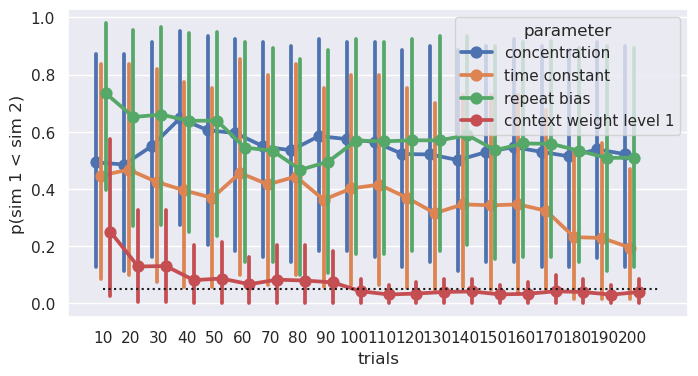

In [23]:
individual_fit_test_file = "Results/Simulations/sim_2_3_bootstrap_test.pkl"
OVERWRITE = True
blocks = range(1,20+1)

if((not os.path.isfile(individual_fit_test_file)) or OVERWRITE):
    pps, param_names =  bootstrap_pop_test([2,3],blocks)

    df_individual_fits = pd.DataFrame()
    for pp, param in enumerate(param_names):
        for bb, bn in enumerate(blocks):
            df_c = pd.DataFrame({"p_2_lt_3" : pps[pp, 0, bb, :],
                                 "p_2_gt_3" : pps[pp, 1, bb, :],
                                 "parameter" : param,
                                 "block" :  bn,
                                 "trials" :  bn * 10});
            df_individual_fits = pd.concat([df_individual_fits, df_c])
    df_individual_fits.to_pickle(individual_fit_test_file);
else:
    df_individual_fits = pd.read_pickle(individual_fit_test_file)

sns.set(rc = {'figure.figsize':(8, 4)})
sns.pointplot(data=df_individual_fits, x="trials", y="p_2_lt_3", hue="parameter", errorbar=("pi",75), dodge=0.5)
plt.plot([0,20],[0.05,0.05],'k:')
plt.ylabel("p(sim 1 < sim 2)")

In [45]:
population_fit_test_file = "Results/Simulations/sim_6_7_auroc_test.pkl"
OVERWRITE = True
blocks = range(1,9+1);

if((not os.path.isfile(population_fit_test_file)) or OVERWRITE):
    aurocs, param_names =  test_posterior_marginals_separation([7,6],blocks)
    #                aurocs[ii, bb, r1,r2] = roc_auc_score(cs["simulation"], cs[pp])
    df_population_fits = pd.DataFrame()
    for pp, param in enumerate(param_names):
        for bb, bn in enumerate(blocks):
            df_c = pd.DataFrame({"auroc" : aurocs[pp, bb, :, :].flatten(),
                                 "aurocm" : 1-aurocs[pp, bb, :, :].flatten(),
                                 "parameter" : param,
                                 "block" : bn,
                                 "trials" : bn * 10});
            df_population_fits = pd.concat([df_population_fits, df_c])
    df_population_fits.to_pickle(population_fit_test_file);
else:
    df_population_fits = pd.read_pickle(population_fit_test_file)


sns.set(rc = {'figure.figsize':(8, 4)})
sns.pointplot(data=df_population_fits, x="trials", y="auroc", hue="parameter", errorbar=("pi",75), dodge=0.5)
plt.plot([0,5],[0.05,0.05],'k:')
plt.ylabel("p(pop. sim 1 < pop. sim 2)")

aurocs.shape

block 0
  run 0


KeyboardInterrupt: 

,auroc,parameter,block
0,0.674926,concentration,0
1,0.589702,concentration,0
2,0.500000,concentration,0
3,0.325074,concentration,0
4,0.224846,concentration,0


In [6]:
def plot_params_over_blocks(sim,block=range(1,11)):
    if(isinstance(sim, pd.DataFrame)):
        a = sim;
    else:
        if(isinstance(sim,int)):
            sim = [sim]
        if(isinstance(block,int)):
            block = [block]

        xlabel = "trials"
        multiplier = 10


        a,_,_ = load_summary(sim,block)
        a.reset_index();

        a[xlabel]  = a["block"] * multiplier
        # a[xlabel] += ((a["simulation"]-np.min(sim))-0.5)*2*0.1

    # nparams = len(a.reset_index()["parameter"].value_counts())
    sns.color_palette("colorblind")
    g = sns.FacetGrid(a, row="parameter", height=1.5, aspect=10/(1.5), sharey=False);
    g.map_dataframe(sns.pointplot, x=xlabel, y=var_to_plot, errorbar=("pi",90), dodge=0.1, hue="simulation", palette=palette);
    g.map_dataframe(sns.pointplot, x=xlabel, y="true",  linestyles="--", markers="", hue="simulation", palette=palette); #
    g.add_legend()
    return g;


In [7]:

def plot_params_per_sim(sim,block):
    if(isinstance(sim,int)):
        sim = [sim]
    assert isinstance(block,int) or len(block)==1, "only one block"
    a,_,_ = load_summary(sim,block)
    a.reset_index();

    dodge = 0.2 if len(sim) > 1 else False;

    g = sns.FacetGrid(a, col="parameter",  height=2, aspect=1, sharey=False);
    g.map_dataframe(sns.stripplot, x="simulation", hue="simulation", y=var_to_plot, dodge=False, alpha=0.75, palette=palette,size=2); #
    g.map_dataframe(sns.pointplot, x="simulation", y="true", dodge=dodge, linestyles="none", markers="d", markersize=6, palette=palette, errorbar=None,linewidth=0.5,alpha=1,  hue="simulation");
    g.map_dataframe(sns.pointplot, x="simulation", y=var_to_plot,
                    dodge=False, linestyles="none", markers="o",
                    markersize=4, palette=palette, errorbar=("pi",90),
                    linewidth=1, alpha=1,  hue="simulation");
    return g;


/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


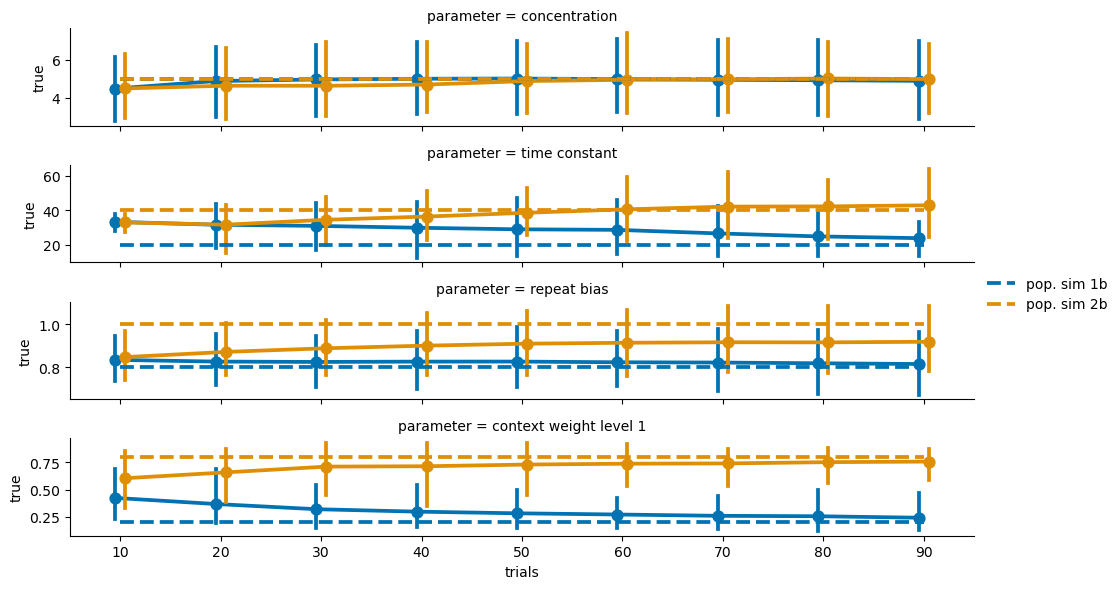

In [8]:
plot_params_over_blocks([6,7],range(1,9+1));

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


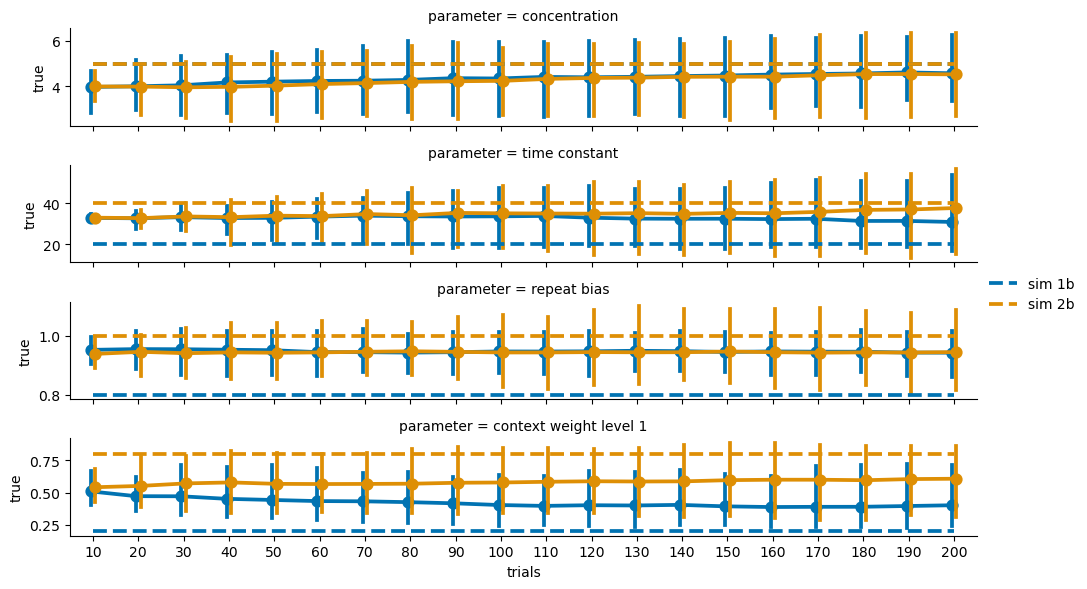

In [9]:
plot_params_over_blocks([2,3],range(1,20+1));

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


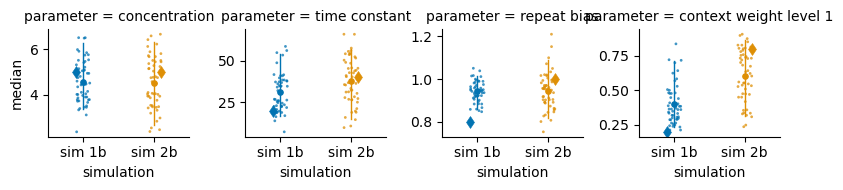

In [13]:
sim = [2,3];
block = 20;
plot_params_per_sim(sim, block)

/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/latimerk/anaconda3/envs/JaiYuLab/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


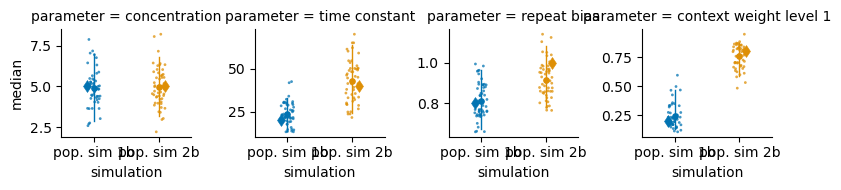

In [14]:
sim = [6,7];
block = 9;
plot_params_per_sim(sim, block)

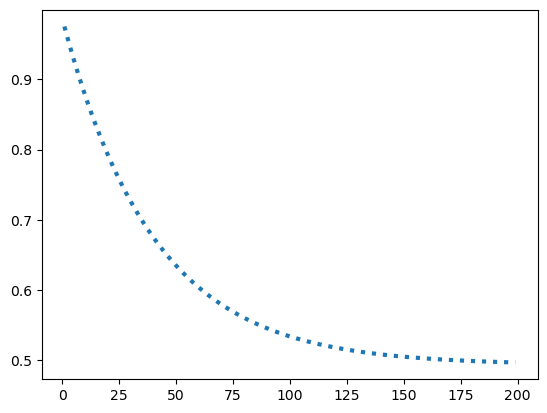

In [12]:
from scipy.stats import gamma
xx = np.arange(0,100,0.05)
# plt.plot(xx, gamma.pdf(xx,2,scale=20))
xx = np.arange(1,200,1)
# plt.plot(xx, np.cumsum(np.exp(-xx/40)))
# plt.plot(xx, np.cumsum(np.exp(-xx/20)),linewidth=3)
plt.plot(xx, np.cumsum(np.exp(-xx/20))/np.cumsum(np.exp(-xx/40)), ':', linewidth=3)